In [99]:
import numpy as np
import time
import itertools as it

import matplotlib.pylab as plt
import matplotlib.lines as mlines
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation
import pickle

# import kmos_tools as KT
import reionizer
import pandas as pd
import scipy.interpolate
import os, sys
import scipy
from scipy import interpolate, integrate, special
from scipy.integrate import ode, solve_ivp, odeint
from scipy.optimize import minimize

import emcee, corner
from multiprocessing import Pool

# import corner
from astropy.cosmology import Planck15, z_at_value
import astropy.units as u
import astropy.constants as const

from matplotlib import rc_file
rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')

%matplotlib inline

import seaborn as sns

plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (4,4)
plt.rcParams['font.size'] = 12

sys.path.append('../')
import bubbles

In [3]:
%load_ext autoreload
%autoreload 2

# Optically thin region

How big is proximity zone around galaxies? What is required ionizing flux to observe blue Lya?

In [4]:
R_p = 200.*u.km/u.s /Planck15.H(z=6.6)
R_p

<Quantity 0.2526515 Mpc>

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/matplotlib/mathtext.py:827: MathTextWarning: Substituting with a symbol from Computer Modern.
  MathTextWarning)


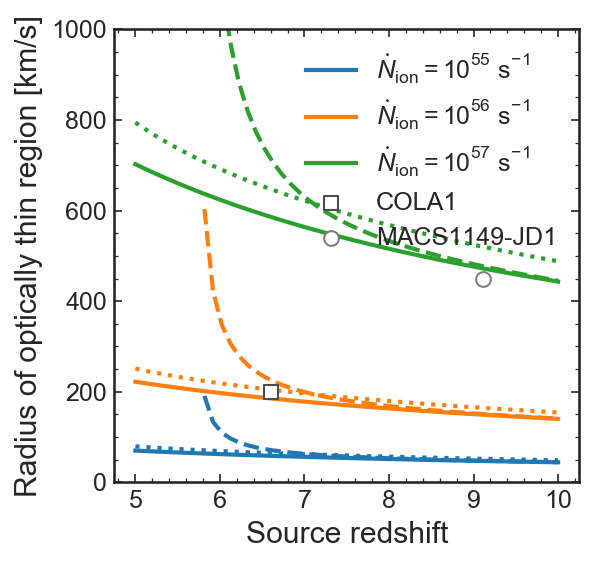

In [5]:
ztab = np.linspace(5., 10)
Ndot_ion_tab = np.logspace(55, 57, 3)/u.s

observations = {}
observations['COLA1'] = {'z':6.6, 'vlim':200, 'M1500':-21.6, 'c':'0.3', 'ms':'s'}
observations['MACS1149-JD1'] = {'z':9.11, 'vlim':450, 'M1500':-18.5, 'c':'0.5', 'ms':'o'}

for ob in observations:
    plt.scatter(observations[ob]['z'], observations[ob]['vlim'], 
                lw=1, edgecolors=observations[ob]['c'], facecolor='w', 
                s=50, marker=observations[ob]['ms'], 
                zorder=100, label=ob)
#     plt.annotate(ob, xy=(observations[ob]['z']-0.1, observations[ob]['vlim']), 
#                  xycoords='data', ha='right', va='center')

for Ndot_ion in Ndot_ion_tab:
    R_alpha = bubbles.R_optically_thin(z=ztab, Ndot_ion=Ndot_ion, alpha_s=-1.8, fesc=1)    
    vlim    = bubbles.blue_velocity_lim(R_alpha, ztab)    
    ln = plt.plot(ztab, vlim, label='$\dot{N}_\mathrm{ion} = 10^{%.0f}$ s$^{-1}$' % np.log10(Ndot_ion.value))

    R_alpha = bubbles.R_optically_thin(z=ztab, Ndot_ion=Ndot_ion, alpha_s=-1.8, fesc=1, J_bg=50)    
    vlim    = bubbles.blue_velocity_lim(R_alpha, ztab)   
    plt.plot(ztab, vlim, c=ln[0].get_color(), ls='dashed')

    R_alpha = bubbles.R_optically_thin(z=ztab, Ndot_ion=Ndot_ion, alpha_s=-2.5, fesc=1, J_bg=1)    
    vlim    = bubbles.blue_velocity_lim(R_alpha, ztab)   
    plt.plot(ztab, vlim, c=ln[0].get_color(), ls='dotted')

plt.legend()

plt.ylim(0., 1000)
plt.xlabel('Source redshift')
plt.ylabel('Radius of optically thin region [km/s]')

plt.savefig('../figs/Ralpha_z.pdf', bbox_inches='tight')

## As a function of Ndot_ion

To compare with Bolton & Haehnelt (2007) ~ 2-5 pMpc for Ndot_ion ~ 1-7e57 s^-1

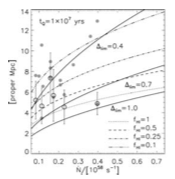

Text(0, 0.5, 'Radius of optically thin region [pMpc]')

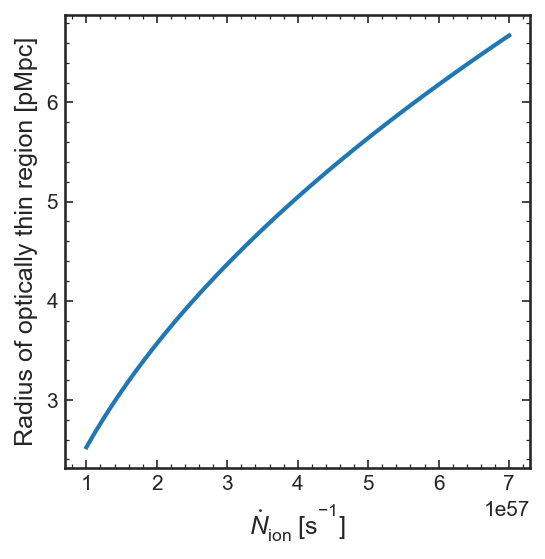

In [6]:
ztest = 6
Ndot_ion_tab = np.linspace(0.1,0.7)*1e58/u.s

R_alpha = bubbles.R_optically_thin(z=ztest, Ndot_ion=Ndot_ion_tab, 
                           reccase='A', alpha_s=-1.5, fesc=1, C=1, T=2e4*u.K)    
    
plt.plot(Ndot_ion_tab, R_alpha)

plt.xlabel('$\dot{N}_\mathrm{ion} \; [$s$^{-1}]$')
plt.ylabel('Radius of optically thin region [pMpc]')

## As a function of UV magnitude

In [7]:
bubbles.Muv_to_Nion(-21.6, z=6.6, alpha_s=-2)

<Quantity 1.48620629e+55 1 / s>

Text(0.5, 0, 'UV magnitude, $M_{1500}$')

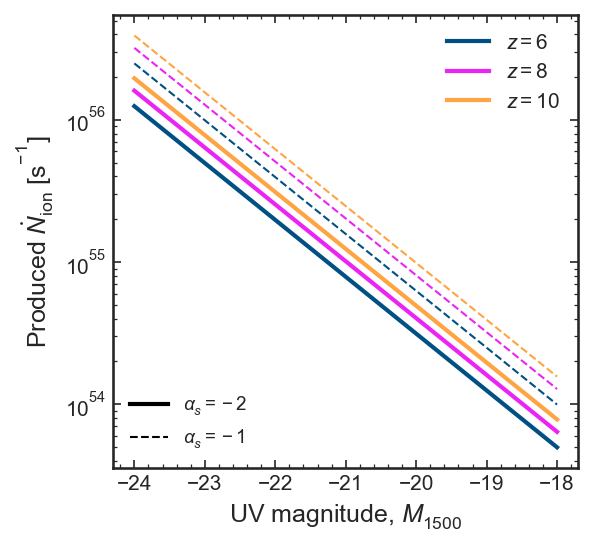

In [8]:
from palettable.cubehelix import cubehelix3_16
col = cubehelix3_16.hex_colors

Muv_tab = np.linspace(-24, -18)
z_test = [6., 8., 10.]
alpha_s_test = [-2., -1.]
lw = [2, 1]
ls = ['solid', 'dashed', 'dotted']

for zz, z in enumerate(z_test):
    ln = plt.plot(Muv_tab, bubbles.Muv_to_Nion(Muv_tab, z=z, alpha_s=alpha_s_test[0]), 
                      lw=lw[0], c=col[3+zz*4], ls=ls[0], label='$z=%.0f$' % z)
    plt.semilogy(Muv_tab, bubbles.Muv_to_Nion(Muv_tab, z=z, alpha_s=alpha_s_test[1]), 
                 lw=lw[1], c=ln[0].get_color(), ls=ls[1])
    
handles = []
for i, alpha_s in enumerate(alpha_s_test):
    ln = mlines.Line2D([], [], color='k', lw=lw[i], ls=ls[i], label=r'$\alpha_s = %.0f$' % alpha_s)
    handles.append(ln)
    
leg = plt.legend(handles=handles, loc='lower left', fontsize=9)
plt.gca().add_artist(leg)

plt.legend()
plt.ylabel('Produced $\dot{N}_\mathrm{ion}$ [s$^{-1}$]')
plt.xlabel('UV magnitude, $M_{1500}$')

0.0
0.6666666666666667


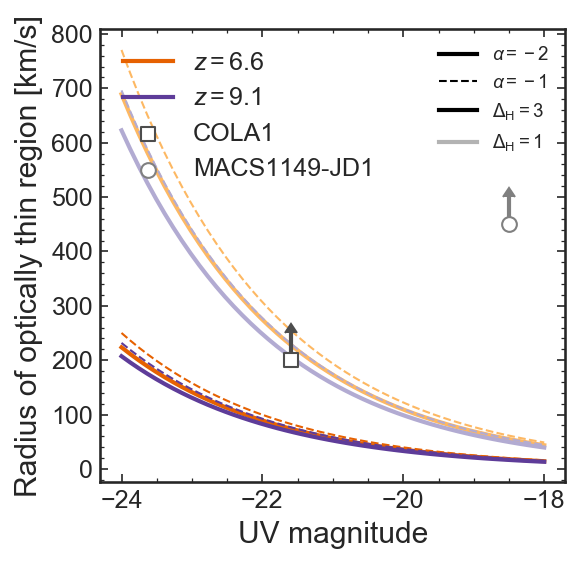

In [102]:
from palettable.colorbrewer.diverging import PuOr_4
col = PuOr_4.hex_colors # o_d, o_l, p_l, p_d


ztest = [6.6, 9.11]#7., 8.]
alpha_s_test = [-2, -1]
C_test = [3, 1]
Muv_tab = np.linspace(-24, -18)

ls = ['solid', 'dashed', 'dotted']
lw = [2, 1, 1]

for ob in observations:
    plt.scatter(observations[ob]['M1500'], observations[ob]['vlim'],
                lw=1, edgecolors=observations[ob]['c'], facecolor='w', 
                s=50, marker=observations[ob]['ms'], 
                zorder=100, label=ob)
    plt.errorbar(observations[ob]['M1500'], observations[ob]['vlim'], 
                    yerr=50, zorder=80,
                    lw=2, color=observations[ob]['c'], lolims=True)  
    
for zz, z in enumerate(ztest):

    for i, alpha_s in enumerate(alpha_s_test):

        Ndot_ion_tab = bubbles.Muv_to_Nion(Muv_tab, z=z, alpha_s=alpha_s, beta=-2)

        for cc, C in enumerate(C_test):
            R_alpha = bubbles.R_optically_thin(z=z, Ndot_ion=Ndot_ion_tab, 
                                   reccase='B', alpha_s=alpha_s, 
                                   fesc=1, C=C, T=1e4*u.K, J_bg=1)        
            vlim = bubbles.blue_velocity_lim(R_alpha, z)   

            # Only make label for C=3 and alpha = -2
            if i == 0 and cc == 0:
                label = '$z=%.1f$' % z
            else:
                label = None
            
            if zz == 0:
                c = col[zz+cc]
                # z=6.6 orange, dark for C = 1 (0)
#                 print(zz+cc)
            else:
                c = col[zz+1+np.abs(cc - 1)]
                # z=9.1 purple, dark for C = 1 (3)
#                 print(zz+1+np.abs(cc - 1))
            plt.plot(Muv_tab, vlim, c=c, ls=ls[i], lw=lw[i], label=label)
        
handles = []
for i, alpha_s in enumerate(alpha_s_test):
    ln = mlines.Line2D([], [], color='k', lw=lw[i], ls=ls[i], label=r'$\alpha = %.0f$' % alpha_s)
    handles.append(ln)
for i, C in enumerate(C_test):
    print(1-C/3.)
    ln = mlines.Line2D([], [], color='%.1f' % (1-C/3.), label=r'$\Delta_\mathrm{H} = %.0f$' % C)
    handles.append(ln)
    
leg = plt.legend(handles=handles, loc='upper right', fontsize=9)
plt.gca().add_artist(leg)

plt.legend(loc='upper left')

plt.xlabel('UV magnitude')
plt.ylabel('Radius of optically thin region [km/s]')

plt.savefig('../figs/Ralpha_Muv.pdf', bbox_inches='tight')

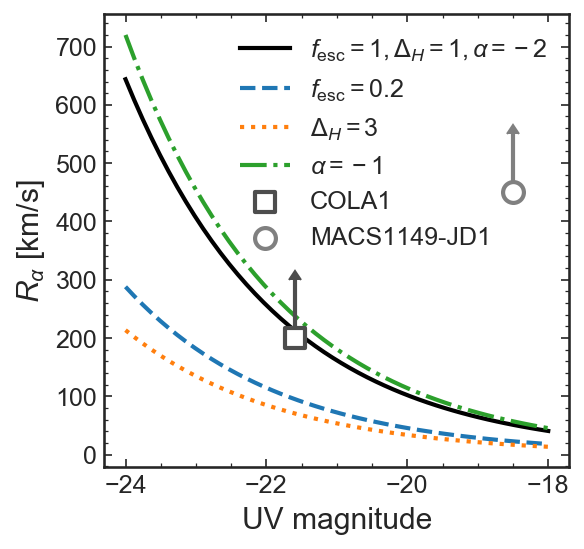

In [161]:
from palettable.colorbrewer.diverging import PuOr_4
col = PuOr_4.hex_colors # o_d, o_l, p_l, p_d

plt.figure()

alpha_s_test = [-2, -1]
C_test = [1, 3]
fesc_test = [1, 0.2]
Muv_tab = np.linspace(-24, -18)

alpha_fid = -2.
fesc_fid = 1.
C_fid = 1.

ls = ['solid', 'dashed', 'dotted']
lw = [2, 1, 1]

for ob in observations:
    plt.scatter(observations[ob]['M1500'], observations[ob]['vlim'],
            lw=2, edgecolors=observations[ob]['c'], facecolor='w', 
            s=100, marker=observations[ob]['ms'], 
            zorder=100, label=ob)
    plt.errorbar(observations[ob]['M1500'], observations[ob]['vlim'], 
                yerr=100, zorder=80,
                lw=2, color=observations[ob]['c'], lolims=True)  


z = 8.

def get_vlim(z, alpha_s, fesc, C):
    
    Ndot_ion_tab = bubbles.Muv_to_Nion(Muv_tab, z=z, alpha_s=alpha_s, beta=-2)

    R_alpha = bubbles.R_optically_thin(z=z, Ndot_ion=Ndot_ion_tab, 
                               reccase='B', alpha_s=alpha_s, 
                               fesc=fesc, C=C, T=1e4*u.K, J_bg=1)        

    vlim = bubbles.blue_velocity_lim(R_alpha, z)  
    
    return vlim

vlim = get_vlim(z=z, alpha_s=alpha_fid, fesc=fesc_fid, C=C_fid)
plt.plot(Muv_tab, vlim, c='k', label=r'$f_\mathrm{esc} = 1, \Delta_H = 1, \alpha = -2$')

vlim = get_vlim(z=z, alpha_s=alpha_fid, fesc=0.2, C=C_fid)
plt.plot(Muv_tab, vlim, ls='dashed', label=r'$f_\mathrm{esc} = 0.2$')

vlim = get_vlim(z=z, alpha_s=alpha_fid, fesc=fesc_fid, C=3)
plt.plot(Muv_tab, vlim, ls='dotted', label=r'$\Delta_H = 3$')

vlim = get_vlim(z=z, alpha_s=-1, fesc=fesc_fid, C=C_fid)
plt.plot(Muv_tab, vlim, ls='dashdot', label=r'$\alpha = -1$')


plt.xlabel('UV magnitude')
plt.ylabel(r'$R_\alpha$ [km/s]')

plt.legend()
plt.savefig('../figs/Ralpha_Muv_all_1panel.pdf', bbox_inches='tight')

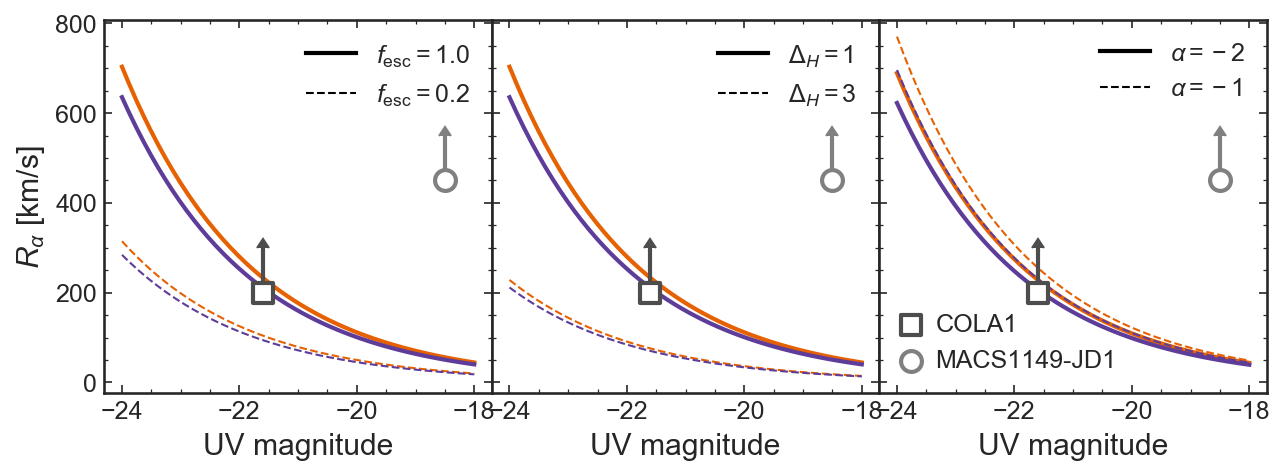

In [151]:
from palettable.colorbrewer.diverging import PuOr_4
col = PuOr_4.hex_colors # o_d, o_l, p_l, p_d

fig, axs = plt.subplots(1,3, figsize=(10, 3.3), dpi=150, sharex=True, sharey=True)
axs = axs.ravel()

ztest = [6.6, 9.11]
alpha_s_test = [-2, -1]
C_test = [1, 3]
fesc_test = [1, 0.2]
Muv_tab = np.linspace(-24, -18)

alpha_fid = -1.8
fesc_fid = 1.
C_fid = 1.

ls = ['solid', 'dashed', 'dotted']
lw = [2, 1, 1]

for ob in observations:
    for i in range(3):
        axs[i].scatter(observations[ob]['M1500'], observations[ob]['vlim'],
                lw=2, edgecolors=observations[ob]['c'], facecolor='w', 
                s=100, marker=observations[ob]['ms'], 
                zorder=100, label=ob)
        axs[i].errorbar(observations[ob]['M1500'], observations[ob]['vlim'], 
                    yerr=100, zorder=80,
                    lw=2, color=observations[ob]['c'], lolims=True)  
    

for zz, z in enumerate(ztest):
    
    c = col[-zz]
    #-----------------------------------------------------------
    # fesc 
    for i, fesc in enumerate(fesc_test):
        
        Ndot_ion_tab = bubbles.Muv_to_Nion(Muv_tab, z=z, alpha_s=alpha_fid, beta=-2)
        
        R_alpha = bubbles.R_optically_thin(z=z, Ndot_ion=Ndot_ion_tab, 
                                   reccase='B', alpha_s=alpha_fid, 
                                   fesc=fesc, C=C_fid, T=1e4*u.K, J_bg=1)        
        
        vlim = bubbles.blue_velocity_lim(R_alpha, z)  
        
        label = r'$f_\mathrm{esc} = %.1f$' % fesc
        axs[0].plot(Muv_tab, vlim, c=c, ls=ls[i], lw=lw[i])
        
    #-----------------------------------------------------------
    # overdensity 
    for i, C in enumerate(C_test):
        
        Ndot_ion_tab = bubbles.Muv_to_Nion(Muv_tab, z=z, alpha_s=alpha_fid, beta=-2)
        
        R_alpha = bubbles.R_optically_thin(z=z, Ndot_ion=Ndot_ion_tab, 
                                   reccase='B', alpha_s=alpha_fid, 
                                   fesc=fesc_fid, C=C, T=1e4*u.K, J_bg=1)        
        
        vlim = bubbles.blue_velocity_lim(R_alpha, z)  
        
        label = r'$\Delta_H = %.0f$' % C
        axs[1].plot(Muv_tab, vlim, c=c, ls=ls[i], lw=lw[i])
        
        #-----------------------------------------------------------
    # fesc 
    for i, alpha_s in enumerate(alpha_s_test):
        
        Ndot_ion_tab = bubbles.Muv_to_Nion(Muv_tab, z=z, alpha_s=alpha_s, beta=-2)
        
        R_alpha = bubbles.R_optically_thin(z=z, Ndot_ion=Ndot_ion_tab, 
                                   reccase='B', alpha_s=alpha_s, 
                                   fesc=fesc_fid, C=C_fid, T=1e4*u.K, J_bg=1)        
        
        vlim = bubbles.blue_velocity_lim(R_alpha, z)  
        
        label = r'$\alpha = %.1f$' % alpha_s
        axs[2].plot(Muv_tab, vlim, c=c, ls=ls[i], lw=lw[i])
            

handles = []
for i, fesc in enumerate(fesc_test):
    ln = mlines.Line2D([], [], color='k', lw=lw[i], ls=ls[i], label = r'$f_\mathrm{esc} = %.1f$' % fesc)
    handles.append(ln)
axs[0].legend(handles=handles)

handles = []
for i, C in enumerate(C_test):
    ln = mlines.Line2D([], [], color='k', lw=lw[i], ls=ls[i], label=r'$\Delta_H = %.0f$' % C)
    handles.append(ln)
axs[1].legend(handles=handles)

handles = []
for i, alpha_s in enumerate(alpha_s_test):
    ln = mlines.Line2D([], [], color='k', lw=lw[i], ls=ls[i], label=r'$\alpha = %.0f$' % alpha_s)
    handles.append(ln)
leg = plt.legend(handles=handles)
plt.gca().add_artist(leg)

axs[2].legend(loc=(-0.01, 0.03), handletextpad=0.)

axs[0].set_xlabel('UV magnitude')
axs[1].set_xlabel('UV magnitude')
axs[2].set_xlabel('UV magnitude')
axs[0].set_ylabel(r'$R_\alpha$ [km/s]')

fig.subplots_adjust(wspace=0.)
plt.savefig('../figs/Ralpha_Muv_all.pdf', bbox_inches='tight')

# Infer properties from proximity zone size

Infer:
- alpha_s
- beta
- C
- fesc

In [10]:
import pdb

def lnlike(theta, vlim, sigma_v, Muv, Muv_err, z, fix_bg):
    """
    Likelihood for observing vlim+sigma_v given theta
    
    Likelihood is that R_alpha > vlim/H(z) --> erfc
    
    """
    
    if fix_bg is True:
        fesc, C, alpha_s = theta
        J_bg = 0.
    
    else:
        fesc, C, alpha_s, gamma_bg_12 = theta    
        J_bg = gamma_bg_12 * 1e-12 / bubbles.Gamma12(z)
    
    
    R_obs     = np.abs(vlim / Planck15.H(z)).to(u.Mpc)
    R_obs_err = np.abs(sigma_v / Planck15.H(z)).to(u.Mpc)

    # Ionizing photon flux
    Muv_draw = np.random.normal(loc=Muv, scale=Muv_err)
    Ndot_ion = bubbles.Muv_to_Nion(Muv_draw, z, alpha_s=alpha_s, beta=-2.)
    
    # Model proximity zone
    R_mod = bubbles.R_optically_thin(z, Ndot_ion=Ndot_ion, alpha_s=alpha_s, 
                                     fesc=fesc, C=C,
                                     reccase='B', T=1e4*u.K, tau_lim=2.3, 
                                     J_bg=J_bg)
    
    if np.isnan(R_mod.value):
        R_mod = np.inf * u.Mpc
    
    likelihood = 0.5 * scipy.special.erfc((R_obs - R_mod) / np.sqrt(2.) / R_obs_err)

    return np.log(likelihood)

def lnprior(theta, fix_bg):
    
    if fix_bg:
        fesc, C, alpha_s = theta
        
        if 0. <= fesc <= 1. and 0.2 < C < 10. \
        and -2.5 <= alpha_s <= -1.:
    #     and -3 < beta < -1 \
            return 0.
        else:
            return -np.inf
        
    else:
        fesc, C, alpha_s, gamma_bg_12 = theta
    
        if 0. <= fesc <= 1. and 0.2 < C < 10. \
        and -2.5 <= alpha_s <= -1. \
        and 0. <= gamma_bg_12 <= 10.:
    #     and -3 < beta < -1 \
            return 0.
        else:
            return -np.inf
    
def lnposterior(theta, vlim, sigma_v, Muv, Muv_err, z, fix_bg):
    
    if lnprior(theta, fix_bg) == 0:
        return lnlike(theta, vlim, sigma_v, Muv, Muv_err, z, fix_bg)
    else:
        return -np.inf    

## Setup up inference

COLA1:

- Max blue peak = 250 km/s
- R~5000 ==> 60 km/s resolution

In [11]:
# Resolution R = l/dl = c/dv
R = 5000.
c = 3e5 * u.km/u.s

v_res = c/R
v_res

<Quantity 60. km / s>

## Fix background = 0

In [12]:
np.random.seed(42)
nll = lambda *args: -lnlike(*args)

initial = np.array([1., 1., -2., 0.1])
initial = np.array([1., 1., -2.,])

vlim, sigma_v, Muv, Muv_err, z, fix_bg = 250.*u.km/u.s, 60.*u.km/u.s, -21.6, 0.3, 6.6, True
soln = minimize(nll, initial, args=(vlim, sigma_v, Muv, Muv_err, z, fix_bg))
soln.x

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


array([ 1.00000519,  0.99999869, -2.00000936])

In [77]:
labels = [r'$f_\mathrm{esc}$', r'$\Delta_H$', r'$\alpha$', r'$\beta_\mathrm{UV}$', r'$\Gamma_\mathrm{bg} [\mathrm{s}^{-1}]$']
labels = [r'$f_\mathrm{esc}$', r'$\Delta_H$', r'$\alpha$', r'$\Gamma_\mathrm{bg} [\mathrm{s}^{-1}]$']
labels = [r'$f_\mathrm{esc}$', r'$\Delta_H$', r'$\alpha$']

pos = initial + 1e-1 * np.random.randn(100, len(soln.x))
nwalkers, ndim = pos.shape

print('%i walkers, %i dimensions' % (nwalkers, ndim))

100 walkers, 4 dimensions


### Run inference

In [14]:
Nsteps = 8000
fix_bg = True

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnposterior, 
                                    args=(vlim, sigma_v, Muv, Muv_err, z, fix_bg),
                                    pool=pool)
    start = time.time()
    sampler.run_mcmc(pos, Nsteps, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

# Autocorrelation time
tau = sampler.get_autocorr_time()

  0%|          | 0/8000 [00:00<?, ?it/s]/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 8000/8000 [03:16<00:00, 40.68it/s]


Multiprocessing took 196.8 seconds


### Plot

In [16]:
sampler.get_autocorr_time()

array([65.35981906, 64.08332785, 65.86189221])

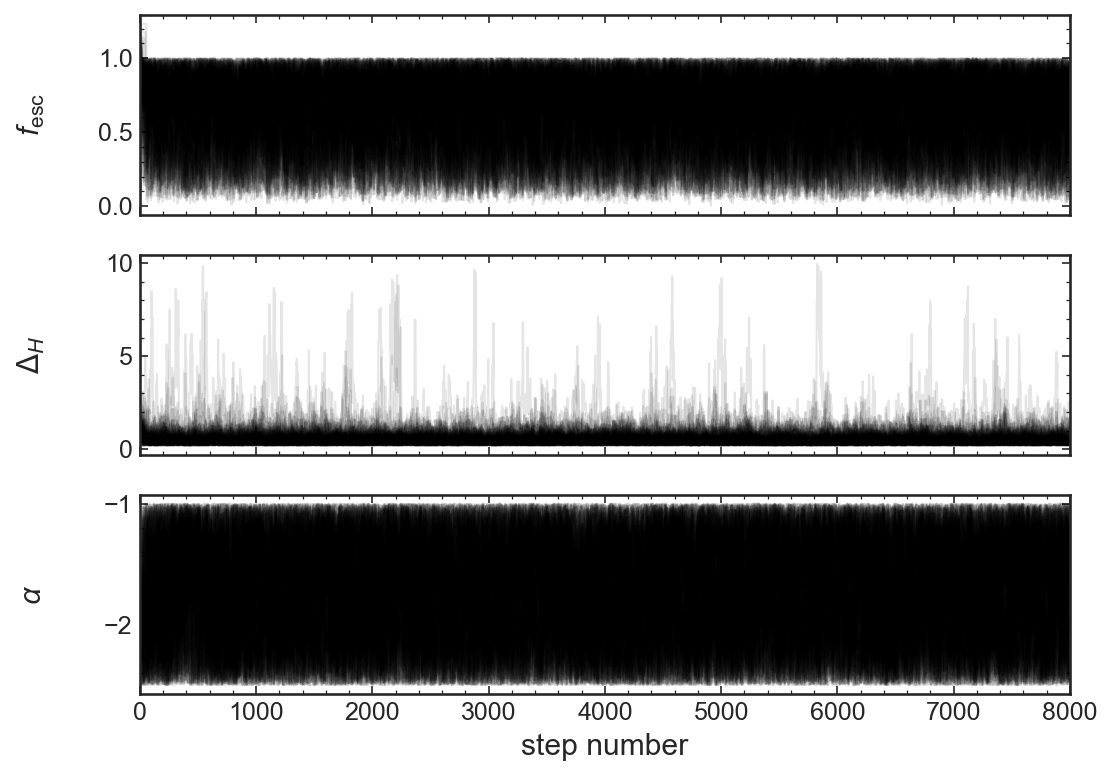

In [17]:
fig, axes = plt.subplots(ndim, figsize=(8, ndim*2), sharex=True)

samples = sampler.get_chain()

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.1, lw=1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

Autocorrelation time suggests that only about 150 steps are needed for the chain to “forget” where it started. 

It’s not unreasonable to throw away a few times this number of steps as “burn-in”. 

Let’s discard the initial 300 steps, thin by about half the autocorrelation time (75 steps), and flatten the chain so that we have a flat list of samples:

In [18]:
flat_samples = sampler.get_chain(discard=300, thin=50, flat=True)
print(flat_samples.shape)

(15400, 3)


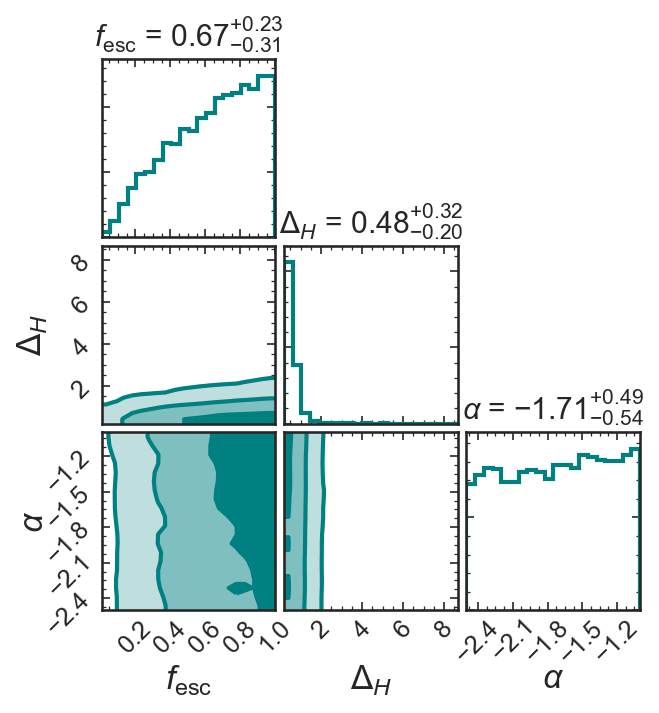

In [19]:
fig, ax = plt.subplots(ndim, ndim, figsize=(ndim+1.4, ndim+1.5), dpi=150)
corner.corner(flat_samples, fig=fig,
                labels=labels, smooth=1, 
                color='Teal', use_math_text=True,
                plot_datapoints=False, plot_density=False, 
                fill_contours=True, hist_kwargs={'lw':2},
#                 quantiles=[0.16, 0.5, 0.84], 
                levels = 1.0 - np.exp(-0.5 * np.array([1,2,3]) ** 2),
#               levels = 1.0 - np.exp(-0.5 * np.arange(0.5, 2.1, 0.5) ** 2),
                show_titles=True, 
                label_kwargs={"fontsize": 16})
plt.savefig('../figs/COLA1_Ralpha_corner.pdf', bbox_inches='tight')
plt.show()

## Let background free

In [20]:
np.random.seed(42)
nll = lambda *args: -lnlike(*args)

initial = np.array([1., 1., -2., 0.1])

vlim, sigma_v, Muv, Muv_err, z, fix_bg = 250.*u.km/u.s, 60.*u.km/u.s, -21.6, 0.3, 6.6, False
soln = minimize(nll, initial, args=(vlim, sigma_v, Muv, Muv_err, z, fix_bg))
soln.x

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:1020: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


array([ 1.00000012,  0.99999997, -2.00000022,  0.10000014])

In [78]:
labels_bg = [r'$f_\mathrm{esc}$', r'$\Delta_H$', r'$\alpha$', r'$\Gamma_\mathrm{bg} [10^{-12} \mathrm{s}^{-1}]$']

pos_bg = initial + 1e-1 * np.random.randn(100, len(soln.x))
nwalkers_bg, ndim_bg = pos_bg.shape

print('%i walkers, %i dimensions' % (nwalkers_bg, ndim_bg))

100 walkers, 4 dimensions


In [22]:
Nsteps = 8000
fix_bg = False

with Pool() as pool:
    sampler_bg = emcee.EnsembleSampler(nwalkers_bg, ndim_bg, lnposterior, 
                                    args=(vlim, sigma_v, Muv, Muv_err, z, fix_bg),
                                    pool=pool)
    start = time.time()
    sampler_bg.run_mcmc(pos_bg, Nsteps, progress=True)
    end = time.time()
    multi_time = end - start
    print("Multiprocessing took {0:.1f} seconds".format(multi_time))

# Autocorrelation time
tau = sampler.get_autocorr_time()

  0%|          | 0/8000 [00:00<?, ?it/s]/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
  0%|          | 3/8000 [00:00<04:54, 27.13it/s]/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
  0%|          | 8/8000 [00:00<04:20, 30.67it/s]/home

Multiprocessing took 196.2 seconds


### Plot

In [24]:
sampler_bg.get_autocorr_time()

array([ 99.10427471,  95.39028477,  94.47646085, 101.78255877])

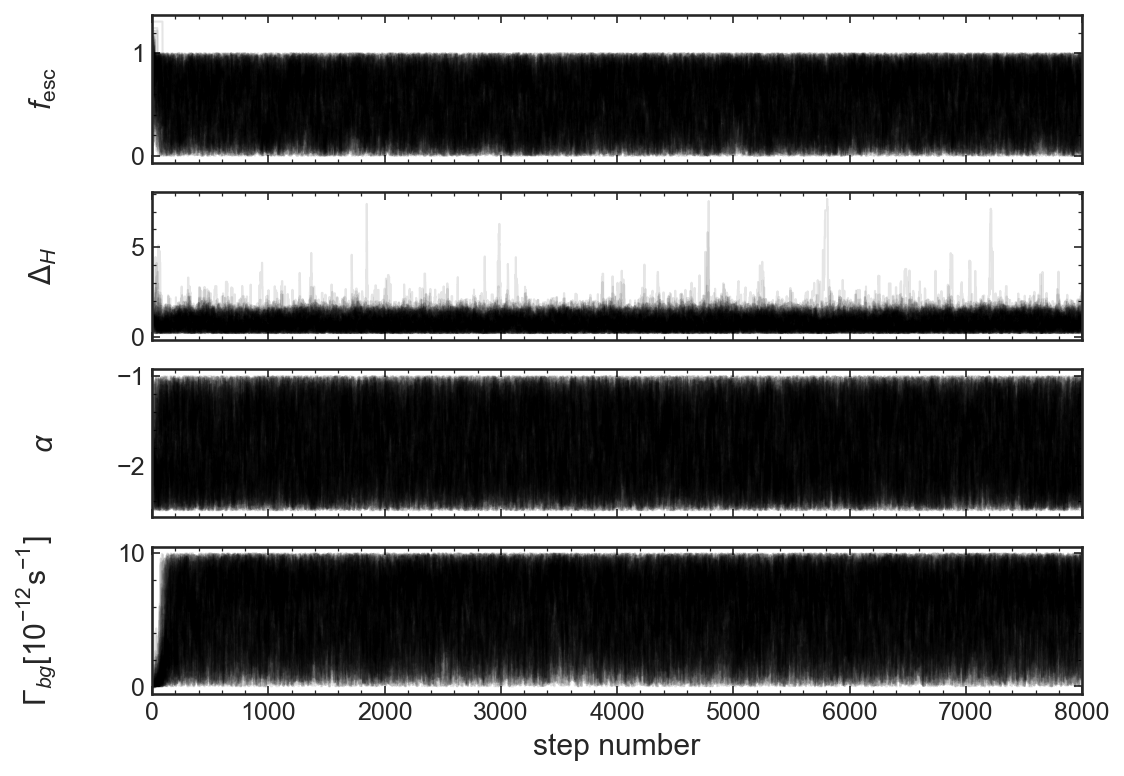

In [25]:
fig, axes = plt.subplots(ndim_bg, figsize=(8, ndim*2), sharex=True)

samples_bg = sampler_bg.get_chain()

for i in range(ndim_bg):
    ax = axes[i]
    ax.plot(samples_bg[:, :, i], "k", alpha=0.1, lw=1)
    ax.set_xlim(0, len(samples_bg))
    ax.set_ylabel(labels_bg[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

(15400, 4)


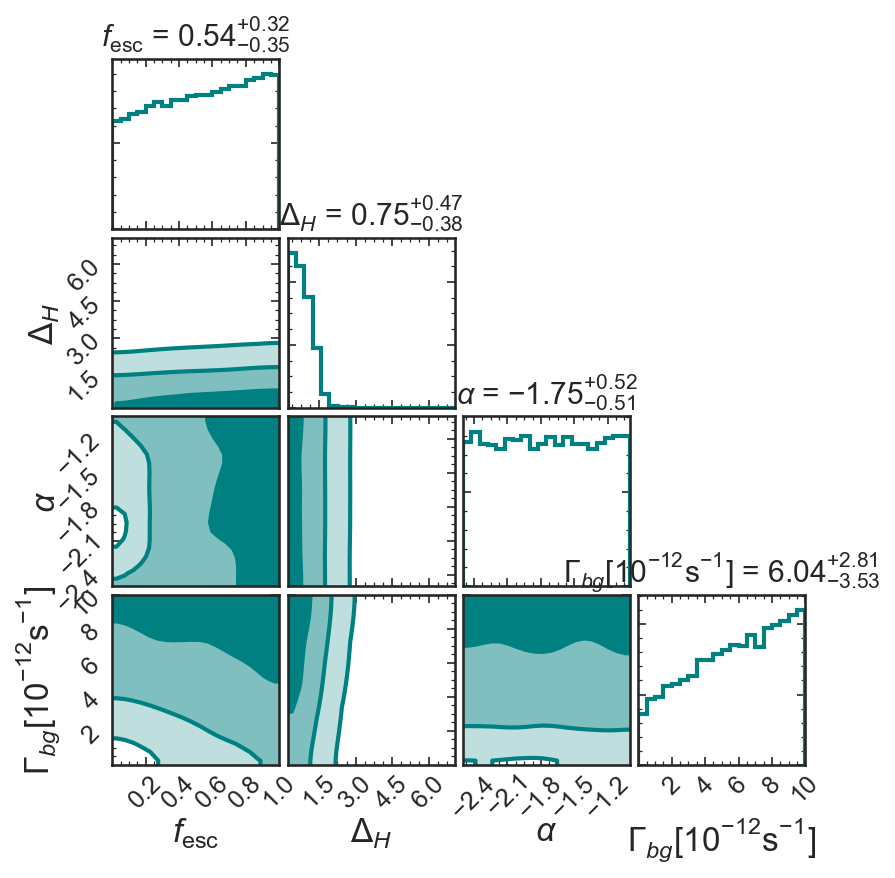

In [26]:
flat_samples_bg = sampler_bg.get_chain(discard=300, thin=50, flat=True)
print(flat_samples_bg.shape)

fig, ax = plt.subplots(ndim_bg, ndim_bg, figsize=(ndim_bg+1.4, ndim_bg+1.5), dpi=150)
corner.corner(flat_samples_bg, fig=fig,
                labels=labels_bg, smooth=2, 
                color='Teal', use_math_text=True,
                plot_datapoints=False, plot_density=False, 
                fill_contours=True, hist_kwargs={'lw':2},
#                 quantiles=[0.16, 0.5, 0.84], 
                levels = 1.0 - np.exp(-0.5 * np.array([1,2,3]) ** 2),
#               levels = 1.0 - np.exp(-0.5 * np.arange(0.5, 2.1, 0.5) ** 2),
                show_titles=True, 
                label_kwargs={"fontsize": 16})

plt.savefig('../figs/COLA1_Ralpha_corner_free_J_bg.pdf', bbox_inches='tight')

## Plot both

NameError: name 'logZ_nobg' is not defined

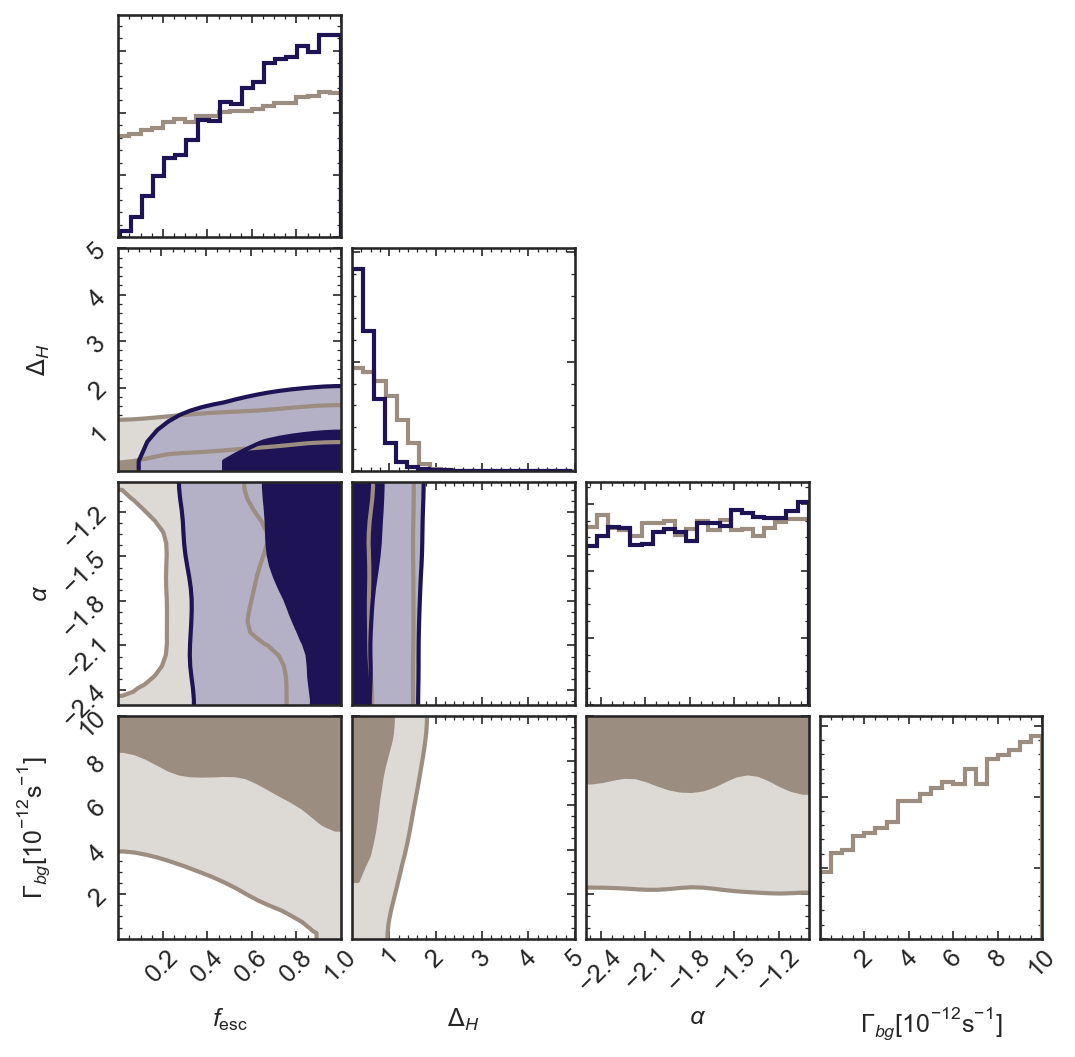

In [32]:
def get_med_errs(array, quantiles=[16., 50., 84.]):
    return [np.percentile(array, q) for q in quantiles]
    
col_bg   = 'grey'
col_nobg = 'tab:blue'

col_bg   = '#9B8D7F'
col_nobg = '#1E1355'

# fig, ax = plt.subplots(ndim_bg, ndim_bg, figsize=(ndim_bg+1.4, ndim_bg+1.5), dpi=100)
fig, ax = plt.subplots(ndim_bg, ndim_bg, figsize=(1.8*ndim_bg, 1.8*ndim_bg), dpi=150)

expand_flat_samples = np.append(flat_samples, -5 + np.random.normal(0., 1, (len(flat_samples),1)), 1)

# With background
corner.corner(flat_samples_bg, fig=fig,
              range=[(0.,1), (0.2,5), (-2.5,-1), (0,10)],
                labels=labels_bg, smooth=2, 
                color=col_bg, use_math_text=True,
                plot_datapoints=False, plot_density=False, 
                fill_contours=True, hist_kwargs={'lw':2, 'density':True},
                levels = 1.0 - np.exp(-0.5 * np.array([1,2]) ** 2),
#                 show_titles=True,        
                label_kwargs={"fontsize": 12})


for i,j in it.product(range(3), range(3)):
    
    # 2D hist
    if i > j:
        corner.hist2d(expand_flat_samples[:,j], expand_flat_samples[:,i], 
                      ax=ax[i,j], bins=20, 
                      levels=1.0 - np.exp(-0.5 * np.array([1,2]) ** 2), 
                      smooth=2, color=col_nobg, 
                      plot_datapoints=False, plot_density=False, plot_contours=True, 
                      no_fill_contours=False, fill_contours=True)
        
    # diagonal
    if i == j:        
        if i == 1:
            data = expand_flat_samples[:,i][expand_flat_samples[:,i] <= 5.]
        else:
            data = expand_flat_samples[:,i]
            
        n, bins, patches = ax[i,j].hist(data, bins=20, histtype='step', color=col_nobg, density=True, lw=2)
        ax[i,j].set_ylim(0., 1.1*np.max(n))
        
# Set delta_H lims        
[axi.set_xlim(0.2,5) for axi in ax[:,1]]
ax[1,0].set_ylim(0.2,5)

# Legend
ax[0,1].annotate('No background ($\ln{Z} = %.2f$)' % logZ_nobg[-1], xy=(0.,0.9), xycoords='axes fraction', color=col_nobg)
for i, label in enumerate(labels):    
    low, med, high = get_med_errs(flat_samples[:,i])
    low_err, high_err = med-low, high-med    
#     ax[0,1].annotate('%s$= %.2f_{-%.2f}^{+%.2f}$' % (label, med, low_err, high_err), xy=(0.,0.7-i/5.), xycoords='axes fraction', color=col_nobg)
    ax[i,i].annotate('%s$= %.2f_{-%.2f}^{+%.2f}$' % (label, med, low_err, high_err), 
                     xy=(0.95,0.3), xycoords='axes fraction', fontsize=9, ha='right', color=col_nobg)
    
# ax[0,2].annotate('With ionizing background', xy=(0.,0.9), xycoords='axes fraction')
ax[0,1].annotate('With ionizing background ($\ln{Z} = %.2f$)' % logZ_withbg[-1], xy=(0.,0.75), xycoords='axes fraction', color='0.4')
for i, label in enumerate(labels_bg):
    low, med, high = get_med_errs(flat_samples_bg[:,i])
    low_err, high_err = med-low, high-med    
#     ax[0,2].annotate('%s$= %.2f_{-%.2f}^{+%.2f}$' % (label, med, low_err, high_err), xy=(0.,0.7-i/5.), xycoords='axes fraction')
    ax[i,i].annotate('%s$= %.2f_{-%.2f}^{+%.2f}$' % (label, med, low_err, high_err), 
                     xy=(0.95,0.1), xycoords='axes fraction', fontsize=9, ha='right', color='0.4')    

plt.savefig('../figs/COLA1_Ralpha_corner_both.pdf', bbox_inches='tight')

# Run with dynesty

In [35]:
# Dynesty imports
from multiprocessing import Pool
import dynesty
from dynesty import plotting as dyplot
from dynesty import DynamicNestedSampler
from dynesty import utils as dyfunc
import ipyparallel as ipp
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import pickle

np.seterr(divide='ignore')

%timeit
%lprun

# To use multiprocessing run following command:
# > ipcluster start -n 7
rc = ipp.Client()
nprocs = len(rc.ids)
print(rc.ids)
dview = rc[:]
dview.use_dill();

[0, 1, 2, 3, 4, 5, 6]


In [372]:
def prior_transform(utheta, args):
    """
    utheta = U(0,1)
    """
    fix_bg_bool = args
    
    if fix_bg_bool is True:
        ufesc, uC, ualpha_s = utheta
        fesc    = ufesc
        C       = 10.2*uC + 0.2
        alpha_s = -(1.5*ualpha_s + 1.)
        return fesc, C, alpha_s        
    else:
        ufesc, uC, ualpha_s, ugamma_bg_12 = utheta
        fesc    = ufesc
        C       = 10.2*uC + 0.2
        alpha_s = -(1.5*ualpha_s + 1.)
        gamma_bg_12 = 10.*ugamma_bg_12
        return fesc, C, alpha_s, gamma_bg_12

In [389]:
chain_file_nobg = "../chains/res_nobg.pickle"
fix_bg = True
maxiter = 10000
if __name__ == '__main__':
   
    # sample from the target distribution
    t0 = time.time()
    npool = 7
    with ProcessPoolExecutor(max_workers=npool) as executor:
        
        sampler = DynamicNestedSampler(
                                lnlike, prior_transform, ndim, 
                                logl_args=(vlim, sigma_v, Muv, Muv_err, z, fix_bg),
                                ptform_args=[fix_bg],
                                pool=executor, queue_size=npool,
                                bound='multi', sample='rwalk')
        
        sampler.run_nested(dlogz_init=0.001, nlive_init=500, maxiter=maxiter, use_stop=False)#wt_kwargs={'pfrac': 1.0})
        
        res_fixbg = sampler.results        
        pickle.dump(res_fixbg, open(chain_file_nobg,"wb"))

    t_run = (time.time()-t0)/60.
    print("Took {0:.10f} mins".format(t_run))

iter: 10000 | batch: 7 | bound: 0 | nc: 11 | ncall: 177338 | eff(%):  5.639 | loglstar: -3.432 <  0.000 < -0.007 | logz: -3.006 +/-  0.067 | stop:    nan                      


Took 2.9106498480 mins


In [391]:
chain_file_wbg = "../chains/res_withbg.pickle"
fix_bg = False
maxiter = 10000
if __name__ == '__main__':
   
    # sample from the target distribution
    t0 = time.time()
    npool = 7
    with ProcessPoolExecutor(max_workers=npool) as executor:
        
        sampler = DynamicNestedSampler(
                                lnlike, prior_transform, ndim_bg, 
                                logl_args=(vlim, sigma_v, Muv, Muv_err, z, fix_bg),
                                ptform_args=[[fix_bg]],
                                pool=executor, queue_size=npool,
                                bound='multi', sample='rwalk')
        
        sampler.run_nested(dlogz_init=0.001, nlive_init=500, maxiter=maxiter, use_stop=False, wt_kwargs={'pfrac': 1.0})
        
        res_withbg = sampler.results 
        pickle.dump(res_withbg, open(chain_file_wbg,"wb"))

    t_run = (time.time()-t0)/60.
    print("Took {0:.10f} mins".format(t_run))

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/astropy/units/quantity.py:463: RuntimeWarning: i

Took 2.2264419754 mins


In [33]:
def dyn_plots(results, corner=True, labels=None):
    # Plot a summary of the run.
    rfig, raxes = dyplot.runplot(results, span=[0.0, (0., 1.1), 0.0, (0., 1.05*np.exp(np.nanmax(results.logz)))])

    # Plot traces and 1-D marginalized posteriors.
    tfig, taxes = dyplot.traceplot(results, labels=labels)

    # Plot the 2-D marginalized posteriors.
    if corner:
        cfig, caxes = dyplot.cornerplot(results, labels=labels, show_titles=True)
    return

def load_samples(chain_file, save=False):
    res = pickle.load(open(chain_file, 'rb'))
    
    samples = res.samples  # samples
    weights = np.exp(res.logwt - res.logz[-1])  # normalized weights
    samples = dyfunc.resample_equal(samples, weights) # Resample weighted samples.
    
    if save:
        np.save(chain_file.replace('.pickle','_samples'), samples)
        
    return samples, res.logz[-1]

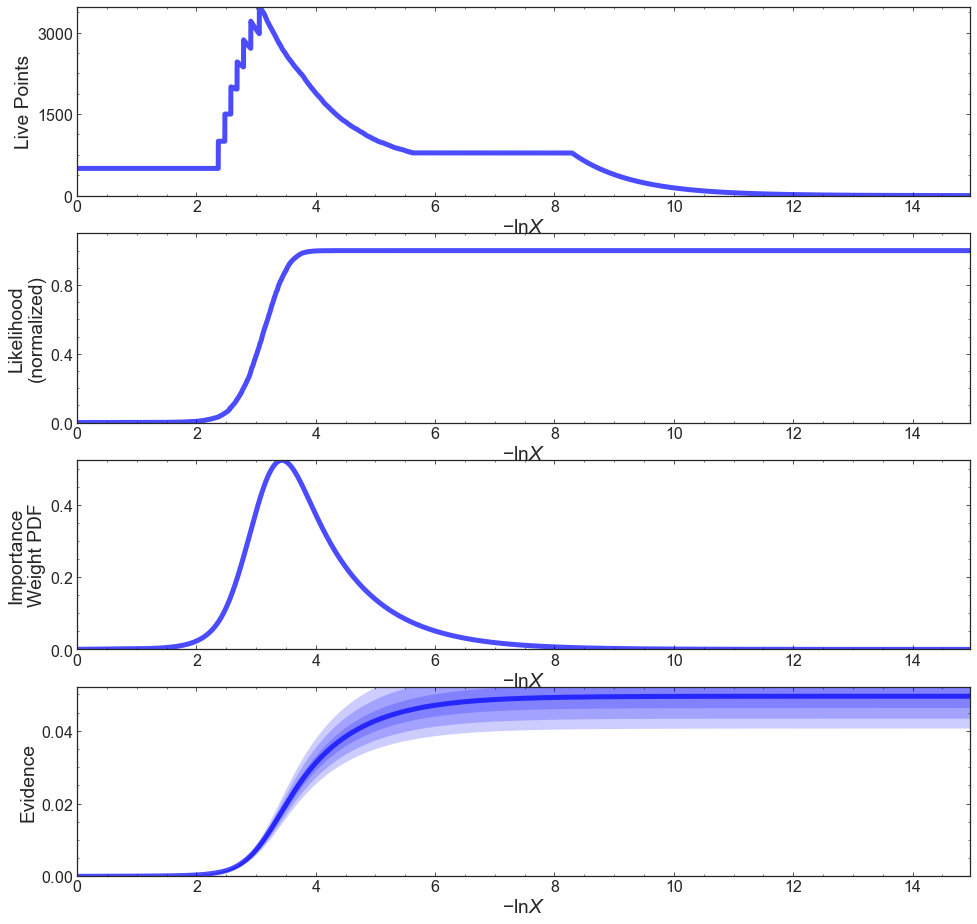

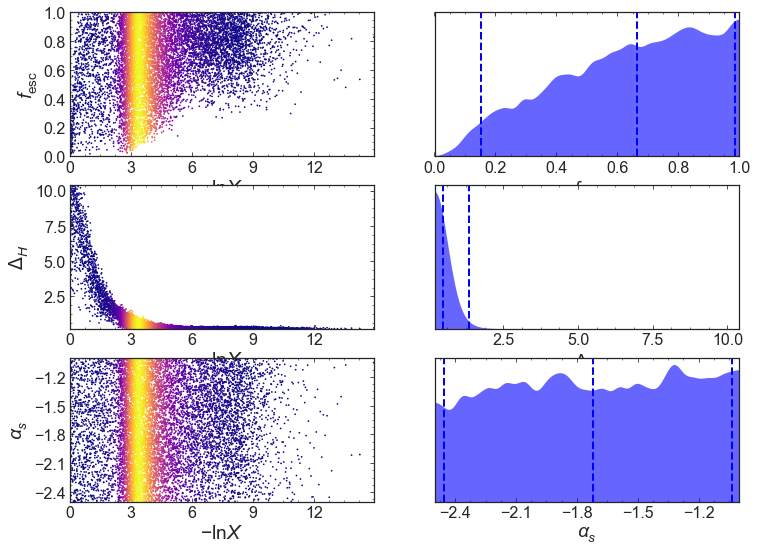

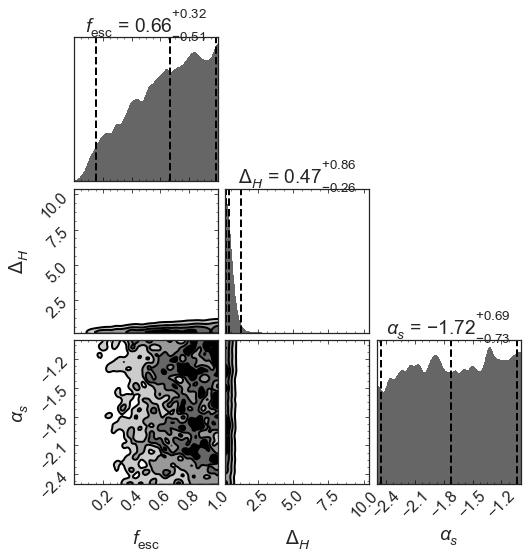

In [390]:
# Plot
dyn_plots(res_fixbg, labels=labels)

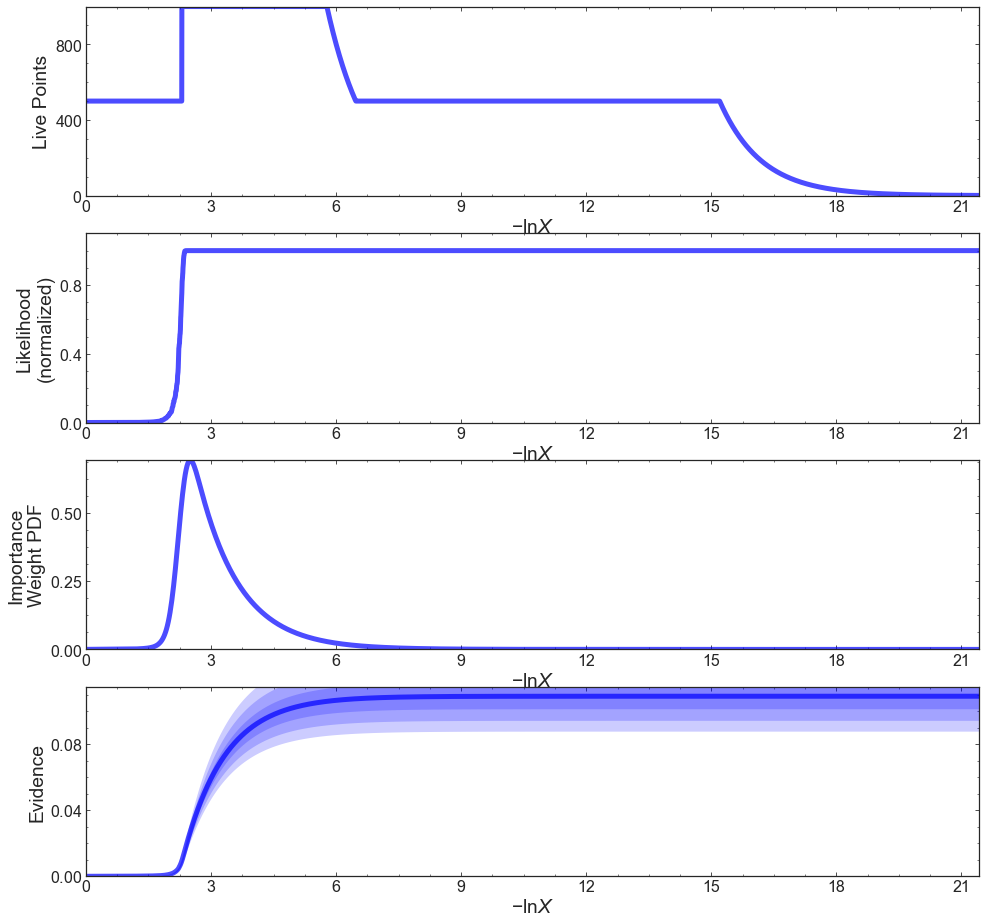

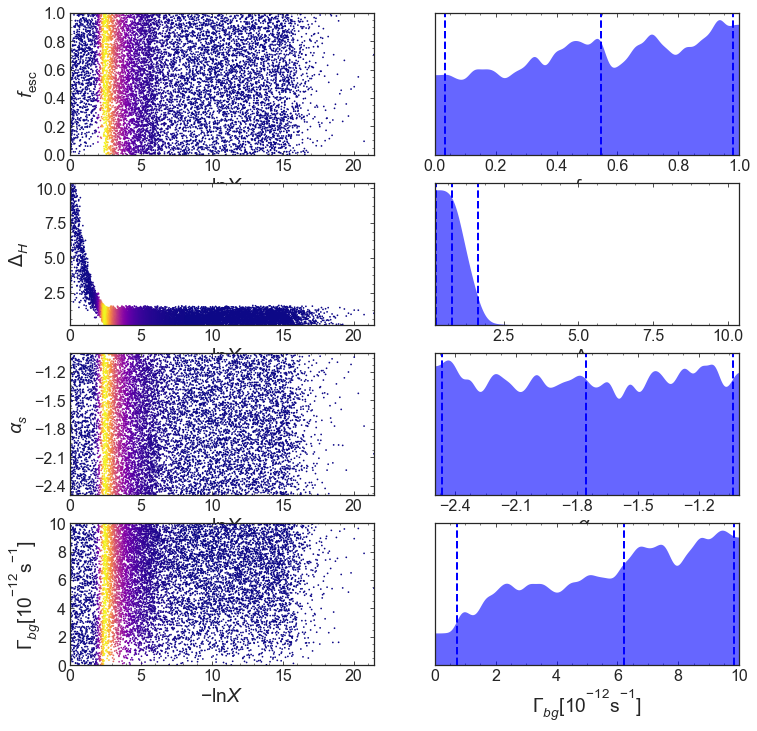

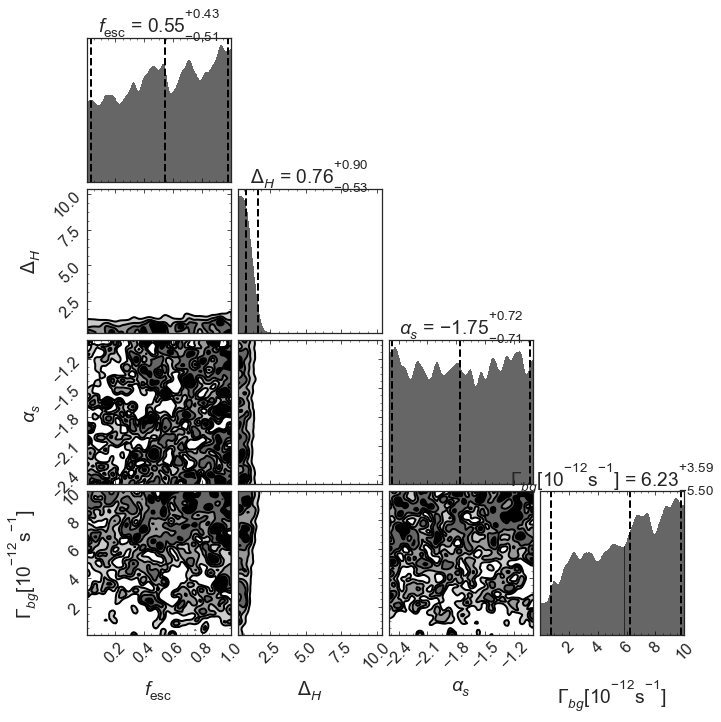

In [392]:
dyn_plots(res_withbg, labels=labels_bg)

In [419]:
logZ_withbg = res_withbg.logz[-100:]
logZ_nobg   = res_fixbg.logz[-100:]

logBF = logZ_withbg - logZ_nobg

print(logZ_withbg[-1], logZ_nobg[-1], np.median(logBF))

print(np.exp(np.median(logBF)))

-2.216415770276438 -3.0063041857098893 0.7902069552478457
2.2038524778989474


In [414]:
sampler.citations

AttributeError: 'DynamicSampler' object has no attribute 'citations'

## Load old runs

In [44]:
chain_file_nobg = "../chains/res_nobg.pickle"
flat_samples_nobg_dynesty, logZ_nobg = load_samples(chain_file_nobg)

chain_file_bg = "../chains/res_withbg.pickle"
flat_samples_bg_dynesty, logZ_withbg = load_samples(chain_file_bg)

print(flat_samples_bg_dynesty.shape, flat_samples_nobg_dynesty.shape)

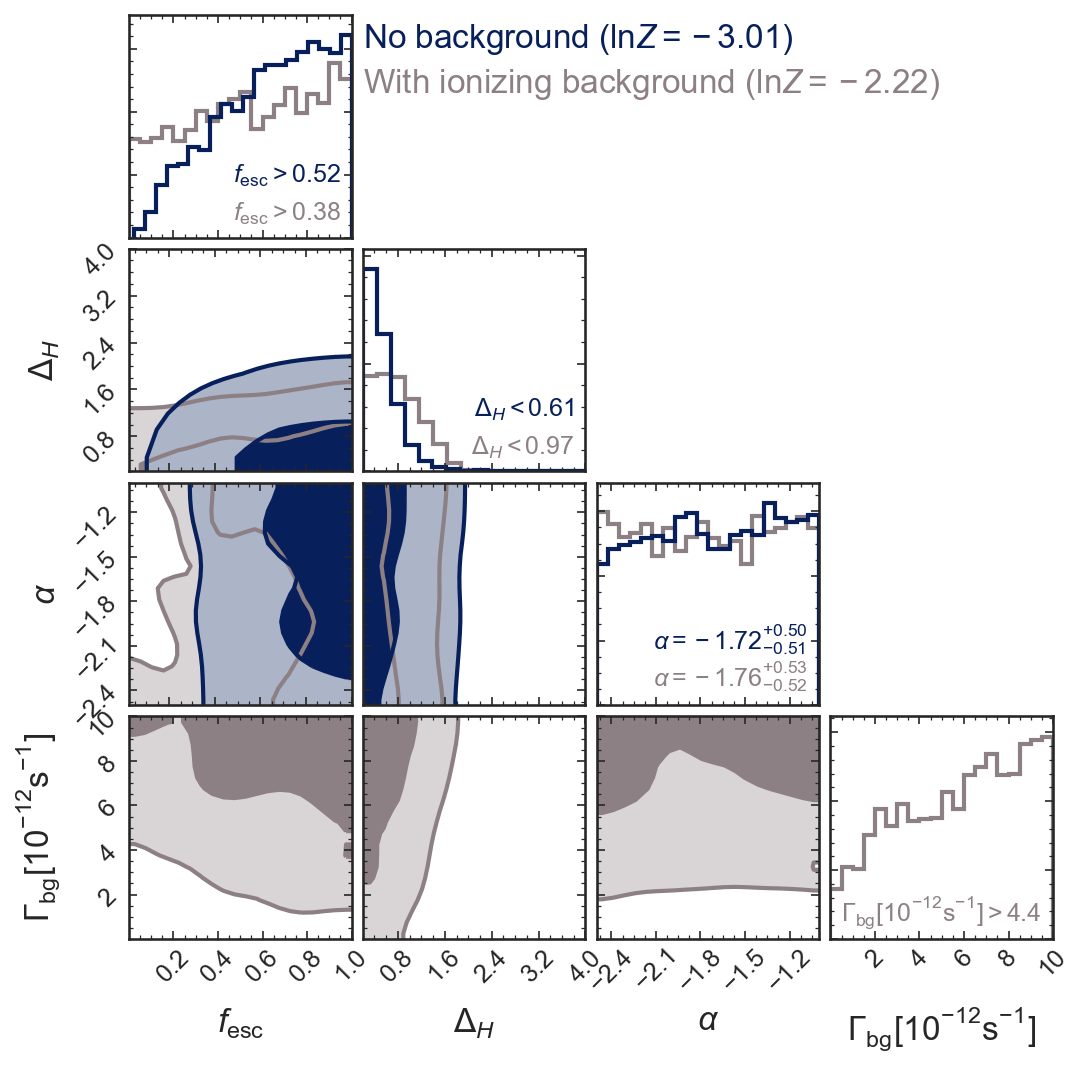

In [101]:
def get_med_errs(array, quantiles=[16., 50., 84.]):
    return [np.percentile(array, q) for q in quantiles]
    
col_bg   = 'grey'
col_nobg = 'tab:blue'

col_bg   = '#8D8085'
col_nobg = '#07205C'

# fig, ax = plt.subplots(ndim_bg, ndim_bg, figsize=(ndim_bg+1.4, ndim_bg+1.5), dpi=100)
fig, ax = plt.subplots(ndim_bg, ndim_bg, figsize=(1.8*ndim_bg, 1.8*ndim_bg), dpi=150)

# No background
expand_flat_samples_nobg_dynesty = np.append(flat_samples_nobg_dynesty, -5 + np.random.normal(0., 1, (len(flat_samples_nobg_dynesty),1)), 1)

# With background
corner.corner(flat_samples_bg_dynesty, fig=fig,
              range=[(0.,1), (0.2,5), (-2.5,-1), (0,10)],
                labels=labels_bg, smooth=2, 
                color=col_bg, use_math_text=True,
                plot_datapoints=False, plot_density=False, 
                fill_contours=True, hist_kwargs={'lw':2, 'density':True},
                levels = 1.0 - np.exp(-0.5 * np.array([1,2]) ** 2),
#                 show_titles=True,        
                label_kwargs={"fontsize": 16})


for i,j in it.product(range(3), range(3)):
    
    # 2D hist
    if i > j:
        corner.hist2d(expand_flat_samples_nobg_dynesty[:,j], expand_flat_samples_nobg_dynesty[:,i], 
                      ax=ax[i,j], bins=20, 
                      levels=1.0 - np.exp(-0.5 * np.array([1,2]) ** 2), 
                      smooth=2, color=col_nobg, 
                      plot_datapoints=False, plot_density=False, plot_contours=True, 
                      no_fill_contours=False, fill_contours=True)
        
    # diagonal
    if i == j:        
        if i == 1:
            data = expand_flat_samples_nobg_dynesty[:,i][expand_flat_samples_nobg_dynesty[:,i] <= 5.]
        else:
            data = expand_flat_samples_nobg_dynesty[:,i]
            
        n, bins, patches = ax[i,j].hist(data, bins=20, histtype='step', color=col_nobg, density=True, lw=2)
        ax[i,j].set_ylim(0., 1.1*np.max(n))
        
# Set delta_H lims        
[axi.set_xlim(0.2,4) for axi in ax[:,1]]
ax[1,0].set_ylim(0.2,4)

# Legend
ax[0,1].annotate('No background ($\ln{Z} = %.2f$)' % logZ_nobg, 
                 xy=(0.,0.85), xycoords='axes fraction', color=col_nobg, fontsize=16)

for i, label in enumerate(labels):    
    if i == 0: # fesc
        low_lim = get_med_errs(expand_flat_samples_nobg_dynesty[:,i], quantiles=[100-68.])
        text = '%s$> %.2f$' % (label, low_lim[0])
    elif i == 1: # D_H
        up_lim = get_med_errs(expand_flat_samples_nobg_dynesty[:,i], quantiles=[68.])
        text = '%s$< %.2f$' % (label, up_lim[0])        
    else:
        low, med, high = get_med_errs(expand_flat_samples_nobg_dynesty[:,i])
        low_err, high_err = med-low, high-med
        text = '%s$= %.2f_{-%.2f}^{+%.2f}$' % (label, med, low_err, high_err)

    ax[i,i].annotate(r'%s' % text, xy=(0.95,0.25), xycoords='axes fraction', fontsize=12, ha='right', color=col_nobg)
    
ax[0,1].annotate('With ionizing background ($\ln{Z} = %.2f$)' % logZ_withbg, 
                 xy=(0.,0.65), xycoords='axes fraction', color=col_bg, fontsize=16)
for i, label in enumerate(labels_bg):
    if i == 0 or i==3: # fesc or gamma
        low_lim = get_med_errs(flat_samples_bg_dynesty[:,i], quantiles=[100-68.])
        if i==0:
            text = '%s$> %.2f$' % (label, low_lim[0])
        else:
            text = '%s$> %.1f$' % (label, low_lim[0])            
    elif i == 1: # D_H
        up_lim = get_med_errs(flat_samples_bg_dynesty[:,i], quantiles=[68.])
        text = '%s$< %.2f$' % (label, up_lim[0])         
    else: #alpha
        low, med, high = get_med_errs(flat_samples_bg_dynesty[:,i])
        low_err, high_err = med-low, high-med
        text = '%s$= %.2f_{-%.2f}^{+%.2f}$' % (label, med, low_err, high_err)

    ax[i,i].annotate(r'%s' % text, xy=(0.95,0.08), xycoords='axes fraction', fontsize=12, ha='right', color=col_bg)

plt.savefig('../figs/COLA1_Ralpha_corner_both.pdf', bbox_inches='tight')

# For same Nion what is xHI in from a single source or multiple?

1.3866650680111756 Mpc


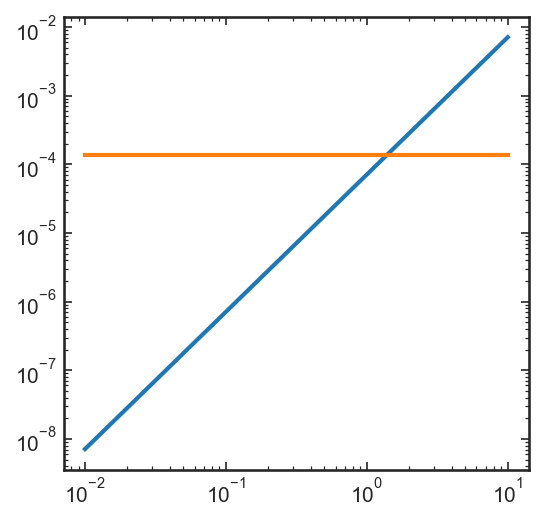

In [63]:
def gamma_s(Ndot_ion=1e55/u.s, fesc=1, alpha=-2):
    sigma_ion0 = 6.3e-18 * u.cm**2
    return -fesc * Ndot_ion * (alpha/alpha-3) * sigma_ion0

def xHI(gamma_s, C=3, z=7, T=1e4):
    return C*bubbles.n_H(z)*bubbles.alpha_rec_B(T)/gamma_s

R_tab = np.logspace(-2,1) * u.Mpc # proper
z_s0 = 7.
Ndot_ion = 1e55/u.s

R_ion = bubbles.R_bubble_CenHaiman2000(z_s0, Ndot_ion=Ndot_ion, t_source=1e8*u.yr)
print(R_ion)

gamma = gamma_s(Ndot_ion=Ndot_ion)

gamma_single_source = gamma/4./np.pi/R_tab.to(u.cm)**2.

plt.loglog(R_tab, xHI(gamma_single_source, z=z_s0))
plt.loglog(R_tab, xHI(gamma/4./np.pi/R_ion.to(u.cm)**2., z=z_s0)*np.ones_like(R_tab))

# source spread through whole bubble


# How much does xHI need to change by to drop Lya fraction by 1/2

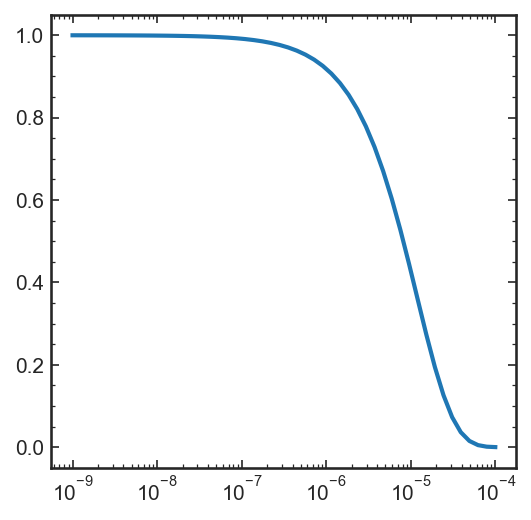

In [19]:
def tau_GP(z, xHI, C=1):
    tau = 1.34e-7*u.cm**3/u.s * C * xHI * bubbles.n_H(z)/Planck15.H(z)
    return tau.to(u.cm/u.cm)

ztab = np.linspace(5,10)
xtab = np.logspace(-9, -4)
plt.semilogx(xtab, np.exp(-(tau_GP(7, xHI=xtab) - tau_GP(6, xHI=xtab))))

In [39]:
def z_at_R(zs, r_p):
    return zs - r_p * Planck15.H(zs) * (1+zs)/const.c

z_at_R(7., r_p=1.*u.Mpc)

<Quantity 6.97719355>

<Quantity 6.97719355>